This was orignally a section in `galaxy properties by environment-updated.ipynb`.  I have no idea what Fatima was looking at in here, but it is not part of the main code.

In [1]:
from astropy.table import Table
from astropy.io import fits
#from astropy.io import ascii

#from sklearn import neighbors
from sklearn.neighbors import NearestNeighbors

import numpy as np

import sys

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker

from scipy import stats
from scipy.integrate import quad

import pickle

import random

# np.set_printoptions(threshold=sys.maxsize)

### Importing data and classification

In [46]:
# data_old = Table.read('data_flags_updated_Oct8.dat', format = 'ascii')
data = Table.read('data_flags_updated_Nov1.dat', format = 'ascii')

In [3]:
# list_ = []
# for i in np.linspace(0.1,2,100):
#     with open('galaxy_in_voidv2_indices'+str(i), 'rb') as ind_file:
#         list_.append(pickle.load(ind_file))
# list_= np.array(list_)
# len(list_)

# #flatten the index file, np.flatten doesnt get it done
# ind_maximal_voidgal=[] # 18 arrays, each contains the list of galaxies within that radius of the maximal sphere
# temp=[]
# for k in range(len(list_)):
#     for i in range(len(list_[k])): #641
#         for j in range(len(list_[k][i])): # number of particles in maximal sphere
#             temp.append(list_[k][i][j]) 
#     ind_maximal_voidgal.append(temp)
#     temp=[]
# ind_maximal_voidgal=np.array(ind_maximal_voidgal)

# np.array(ind_maximal_voidgal).shape

In [47]:
# ra,dec,z
ra = np.array(data['ra'])
dec = np.array(data['dec'])
z = np.array(data['redshift'])

#stellar mass
Mstar = np.array(data['Mstar'])
# Mstar = Mstar[np.logical_not(np.isnan(Mstar))] 
Mstar_NSA= np.array(data['Mstar_NSA'])
# color
u_r = np.array(data['u_r'])
# u_r = u_r[np.logical_not(np.isnan(u_r))] 

g_r = np.array(data['g_r'])
# g_r = g_r[np.logical_not(np.isnan(g_r))] 

# u_r_NSA = np.array(data['u_r_NSA'])
# g_r_NSA = np.array(data['g_r_NSA'])
# absolute magniture
rabsmag = np.array(data['rabsmag'])
# rabsmag = rabsmag[np.logical_not(np.isnan(rabsmag))] 

rabsmag_NSA = np.array(data['rabsmag_NSA'])
#star formation rate and specific SPR
SFR  = np.array(data['SFR'])
# SFR = SFR[np.logical_not(np.isnan(SFR))] 

sSFR = np.array(data['sSFR'])
# sSFR = sSFR[np.logical_not(np.isnan(sSFR))] 

#classification V^2

wall_v2 = np.argwhere(data['flag_vsquared'] == 0).flatten()
void_v2 = np.argwhere(data['flag_vsquared'] == 1).flatten()
edge_v2 = np.argwhere(data['flag_vsquared'] == 2).flatten()
out_v2 = np.argwhere(data['flag_vsquared'] == 9).flatten()

#classification voidfinder

wall_vf = np.argwhere(data['flag_voidfinder'] == 0).flatten()
void_vf = np.argwhere(data['flag_voidfinder'] == 1).flatten()
edge_vf = np.argwhere(data['flag_voidfinder'] == 2).flatten()
out_vf = np.argwhere(data['flag_voidfinder'] == 9).flatten()

# len(wall_v2)+len(void_v2)+len(edge_v2)+len(out_v2),len(wall_vf)+len(void_vf)+len(edge_vf)+len(out_vf), len(data) #check

In [43]:
all_survey = data[data['redshift']< 0.1026]

In [212]:
np.max(all_survey['dec'])-np.min(all_survey['dec'])

81.505031

In [59]:
wall_vf_survey = np.argwhere(all_survey['flag_voidfinder'] == 0).flatten()
void_vf_survey = np.argwhere(all_survey['flag_voidfinder'] == 1).flatten()
edge_vf_survey = np.argwhere(all_survey['flag_voidfinder'] == 2).flatten()
out_vf_survey = np.argwhere(all_survey['flag_voidfinder'] == 9).flatten()

wall_v2_survey = np.argwhere(all_survey['flag_vsquared'] == 0).flatten()
void_v2_survey = np.argwhere(all_survey['flag_vsquared'] == 1).flatten()
edge_v2_survey = np.argwhere(all_survey['flag_vsquared'] == 2).flatten()
out_v2_survey = np.argwhere(all_survey['flag_vsquared'] == 9).flatten()

In [ ]:
# all_survey = data[data['redshift']< 0.1026]
# glx_M_ind = np.logical_and(all_survey['rabsmag']>-18.2, all_survey['rabsmag']<-16.8)

# wall_vf_M_ind = all_survey[glx_M_ind]['flag_voidfinder'] ==0
# void_vf_M_ind = all_survey[glx_M_ind]['flag_voidfinder'] ==1

# void_v2_M_ind = all_survey[glx_M_ind]['flag_vsquared'] ==1
# wall_v2_M_ind = all_survey[glx_M_ind]['flag_vsquared'] ==0



In [190]:
glx_M_ind = np.logical_and(all_survey['rabsmag']>-18.2, all_survey['rabsmag']<-16.8) # index from all survey of 
# galaxies with -18.2<M<-16.8 total of 29433 galaxies.
# out of these for  #np.sum(all_survey[glx_M_ind]['flag_vsquared'] ==9)
#---VF: 14035 are wall , 8506 are void, 6892 are edge , 0 outside.
#---V2: 11716 are wall , 14665 are void, 3039 are edge , 13 outside.

In [196]:
wall_v2_M_ind = all_survey[glx_M_ind]['flag_vsquared'] ==0
wall_vf_M_ind = all_survey[glx_M_ind]['flag_voidfinder'] ==0

void_v2_M_ind = all_survey[glx_M_ind]['flag_vsquared'] ==1
void_vf_M_ind = all_survey[glx_M_ind]['flag_voidfinder'] ==1

In [38]:



c = 299792




def f(a,omega_m):
     return 1/(np.sqrt(a*omega_m*(1+((1-omega_m)*a**3/omega_m))))



def Distance(z,omega_m,h):
    dist = np.ones(len(z))
    H0 = 100*h
    for i,redshift in enumerate(z):
        a_start = 1/(1+redshift)
        I = quad(f,a_start,1,args=omega_m)
        dist[i] = I[0]*(c/H0)
    return dist

# def Rabsmag(omega_m,app_mag,z,h):
#     comovingdist = Distance(z,omega_m,h)*1e6
#     return app_mag -(5*np.log10(comovingdist))+5

In [213]:
from astropy import units as u

In [220]:
d = 301*u.parsec*10**(-6)

In [225]:
d

<Quantity 0.000301 pc>

In [230]:
ra_=(360*u.deg).to(u.rad)
dec_=(81*u.deg).to(u.rad)

In [231]:
A=(ra_/2)*(301**2) #Mpc^2
A

<Quantity 284631.43600789 rad>

In [221]:
ra=s/d  # radi

UnitConversionError: 'pc' (length) and 'deg' (angle) are not convertible

In [209]:
Distance([0,0.1026],0.26,1)  #Mpc

array([  0.        , 301.27299424])

In [195]:
np.max(all_survey[glx_M_ind][wall_vf_M_ind]['redshift'])-np.min(all_survey[glx_M_ind][wall_vf_M_ind]['redshift'])

0.046657

In [194]:
np.max(all_survey[glx_M_ind][wall_v2_M_ind]['redshift'])-np.min(all_survey[glx_M_ind][wall_v2_M_ind]['redshift'])

0.050605

In [198]:
np.max(all_survey[glx_M_ind][void_v2_M_ind]['redshift'])-np.min(all_survey[glx_M_ind][void_v2_M_ind]['redshift'])

0.048368

In [199]:
np.max(all_survey[glx_M_ind][wall_v2_M_ind]['redshift'])-np.min(all_survey[glx_M_ind][wall_v2_M_ind]['redshift'])

0.050605

In [183]:
all_survey[glx_M_ind][wall_vf_M_ind]['redshift']

<Column name='redshift' dtype='float64' length=0>

In [182]:
np.max(all_survey[glx_M_ind][wall_vf_M_ind]['redshift'])-np.min(all_survey[glx_M_ind][wall_vf_M_ind]['redshift'])

ValueError: zero-size array to reduction operation maximum which has no identity

In [171]:
len(wall_v2_M_ind), len(glx_M_ind)

(29433, 366727)

In [160]:
z_gap=[]
ra_gap=[]
dec_gap=[]
z_max=[]
z_min=[]
for i in range(500):
    a = np.random.uniform(-22+(18.2-16.8),-16+(18.2-16.8))
    b = a-(18.2-16.8)
#     a,b
    glx_M_ind_test = np.logical_and(all_survey['rabsmag']>b, all_survey['rabsmag']<a) # index from all survey of 
    z_gap.append((np.max(all_survey[glx_M_ind_test]['redshift'])-np.min(all_survey[glx_M_ind_test]['redshift'])))
    ra_gap.append((np.max(all_survey[glx_M_ind_test]['ra'])-np.min(all_survey[glx_M_ind_test]['ra'])))
    dec_gap.append((np.max(all_survey[glx_M_ind_test]['dec'])-np.min(all_survey[glx_M_ind_test]['dec'])))
    z_max.append(np.max(all_survey[glx_M_ind_test]['redshift']))
    z_min.append(np.min(all_survey[glx_M_ind_test]['redshift']))

    # total redshift gap: 0.1026, dec_gap=81.505031, ra_gap=359.988597
#     z_gap,ra_gap,dec_gap

In [237]:
0.095261, 0.099704,0.080,0.04

[-20.6, -19.200000000000003, -17.800000000000004, -16.400000000000006]

In [249]:
glx_M_ind_test = np.logical_and(all_survey['rabsmag']>-22+4*(18.2-16.8), all_survey['rabsmag']<-22+5*(18.2-16.8)) # index from all survey of 
z_gap=(np.max(all_survey[glx_M_ind_test]['redshift'])-np.min(all_survey[glx_M_ind_test]['redshift']))
ra_gap=(np.max(all_survey[glx_M_ind_test]['ra'])-np.min(all_survey[glx_M_ind_test]['ra']))
dec_gap=(np.max(all_survey[glx_M_ind_test]['dec'])-np.min(all_survey[glx_M_ind_test]['dec']))
z_max=np.max(all_survey[glx_M_ind_test]['redshift'])
z_min=np.min(all_survey[glx_M_ind_test]['redshift'])

In [250]:
z_gap

0.02461

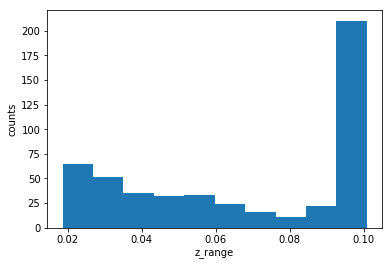

In [232]:
plt.hist(z_gap) # similar to z_max
plt.xlabel("z_range")
plt.ylabel("counts")
plt.show()

(0.07550100000000001, 359.95642699999996, 81.348173)

In [105]:
np.max(all_survey[glx_M_ind]['redshift'])

0.052938

In [100]:
(np.max(all_survey[glx_M_ind]['redshift'])-np.min(all_survey[glx_M_ind]['redshift']))

0.051803999999999996

In [102]:
(np.max(all_survey[glx_M_ind]['ra'])-np.min(all_survey[glx_M_ind]['ra'])), np.max(all_survey['ra'])-np.min(all_survey['ra'])

(359.88966500000004, 359.98859799999997)

In [103]:
(np.max(all_survey[glx_M_ind]['dec'])-np.min(all_survey[glx_M_ind]['dec'])), np.max(all_survey['dec'])-np.min(all_survey['dec'])

(81.333935, 81.505031)

In [55]:
np.sum(glx_M_ind)

29433

In [10]:
len(void_vf)/len(wall_vf), len(wall_v2)/len(void_v2)

(0.501055631519114, 0.5258210572719592)

In [22]:
print("why would the galaxies with -18<M<-16 be more likely to fall in the walls of v^2. if they subtend a small volume of the survey ")

why would the galaxies with -18<M<-16 be more likely to fall in the walls of v^2. if they subtend a small volume of the survey 


In [19]:
len(wall_v2), len(void_v2)

(114507, 217768)

In [33]:
np.intersect1d??

In [35]:
len(np.unique(wall_v2)), len(wall_v2)

(114507, 114507)

In [30]:
inter_wall = np.intersect1d(wall_vf, wall_v2, return_indices=True)

In [40]:
len(wall_v2), len(wall_vf), len(inter_wall[0])

(114507, 190881, 58814)

In [36]:
wall_vf[np.array(inter_wall)[1]]

array([   466,    471,    594, ..., 707812, 707813, 707816])

In [37]:
wall_v2[np.array(inter_wall)[2]]

array([   466,    471,    594, ..., 707812, 707813, 707816])

In [14]:
len(np.intersect1d(void_vf, void_v2)), len(void_vf), len(void_v2)

(66867, 95642, 217768)

In [17]:
len(np.intersect1d(void_v2, wall_vf)), len(void_v2), len(wall_vf)

(131980, 217768, 190881)

### void environment of galaxies with apparents magnitude <-20 and >-20

In [24]:
bright_ind=np.argwhere(data['rabsmag'] <-20).flatten()

In [28]:
bright_wall_v2=np.intersect1d(wall_v2,bright_ind)
bright_out_v2=np.intersect1d(out_v2,bright_ind)
bright_void_v2=np.intersect1d(void_v2,bright_ind)
bright_edge_v2=np.intersect1d(edge_v2,bright_ind)

bright_wall_vf=np.intersect1d(wall_vf,bright_ind)
bright_out_vf=np.intersect1d(out_vf,bright_ind)
bright_void_vf=np.intersect1d(void_vf,bright_ind)
bright_edge_vf=np.intersect1d(edge_vf,bright_ind)

In [29]:
faint_ind=np.argwhere(data['rabsmag'] >-20).flatten()

In [30]:
faint_wall_v2=np.intersect1d(wall_v2,faint_ind)
faint_out_v2=np.intersect1d(out_v2,faint_ind)
faint_void_v2=np.intersect1d(void_v2,faint_ind)
faint_edge_v2=np.intersect1d(edge_v2,faint_ind)

faint_wall_vf=np.intersect1d(wall_vf,faint_ind)
faint_out_vf=np.intersect1d(out_vf,faint_ind)
faint_void_vf=np.intersect1d(void_vf,faint_ind)
faint_edge_vf=np.intersect1d(edge_vf,faint_ind)

In [188]:
def hist_bright(voidfinder=True):
    if voidfinder:
        wall=bright_wall_vf
        void=bright_void_vf
        edge=bright_edge_vf
        out=bright_out_vf
        label="bright VF"
    if voidfinder ==False:
        wall=bright_wall_v2
        void=bright_void_v2
        edge=bright_edge_v2
        out=bright_out_v2     
        label="bright V2"
    plt.figure(figsize=(35, 20))
    plt.hist(rabsmag[edge], label="edge",bins=np.linspace(-21,-5, 350), color="purple", alpha=0.4)
    plt.hist(rabsmag[wall], alpha =0.5, color="green",label="wall",bins=np.linspace(-23,-19.9, 250))
    plt.hist(rabsmag[bright_ind], alpha =0.1,color='gray', label="all faint",bins=np.linspace(-23,-19.9, 250))

#     plt.hist(rabsmag[out], alpha=0.4, color="blue",label="out",bins=np.linspace(-23,-19.9, 250))
    plt.hist(rabsmag[void], alpha =0.4,color="red", label="void",bins=np.linspace(-23,-19.9, 250))
    plt.title(label, fontsize=35)
    plt.legend(fontsize=35)
    plt.xlim(-19.8,-23.1)
    plt.xlabel("abs_mag", fontsize=35)
    plt.show()

In [194]:
def hist_faint(voidfinder=True):
    if voidfinder:
        wall=faint_wall_vf
        void=faint_void_vf
        edge=faint_edge_vf
        out=faint_out_vf
        label="faint VF"
    if voidfinder ==False:
        wall=faint_wall_v2
        void=faint_void_v2
        edge=faint_edge_v2
        out=faint_out_v2     
        label="faint V2"
    plt.figure(figsize=(35, 20))
    plt.hist(rabsmag[edge], label="edge",bins=np.linspace(-21,-5, 350), color="purple", alpha=0.4)
    plt.hist(rabsmag[wall], alpha =0.5, color="green",label="wall",bins=np.linspace(-21,-5, 200))
    plt.hist(rabsmag[faint_ind], alpha =0.2,color='gray', label="all faint",bins=np.linspace(-21,-5, 200))

#     plt.hist(rabsmag[out], alpha=0.4, color="blue",label="out",bins=np.linspace(-21,-5, 200))
    plt.hist(rabsmag[void], alpha =0.4,color="red", label="void",bins=np.linspace(-21,-5, 200))
    plt.title(label, fontsize=35)
    plt.legend(fontsize=35)
    plt.xlim(-5,-21)
    plt.xlabel("abs_mag", fontsize=35)

    plt.show()

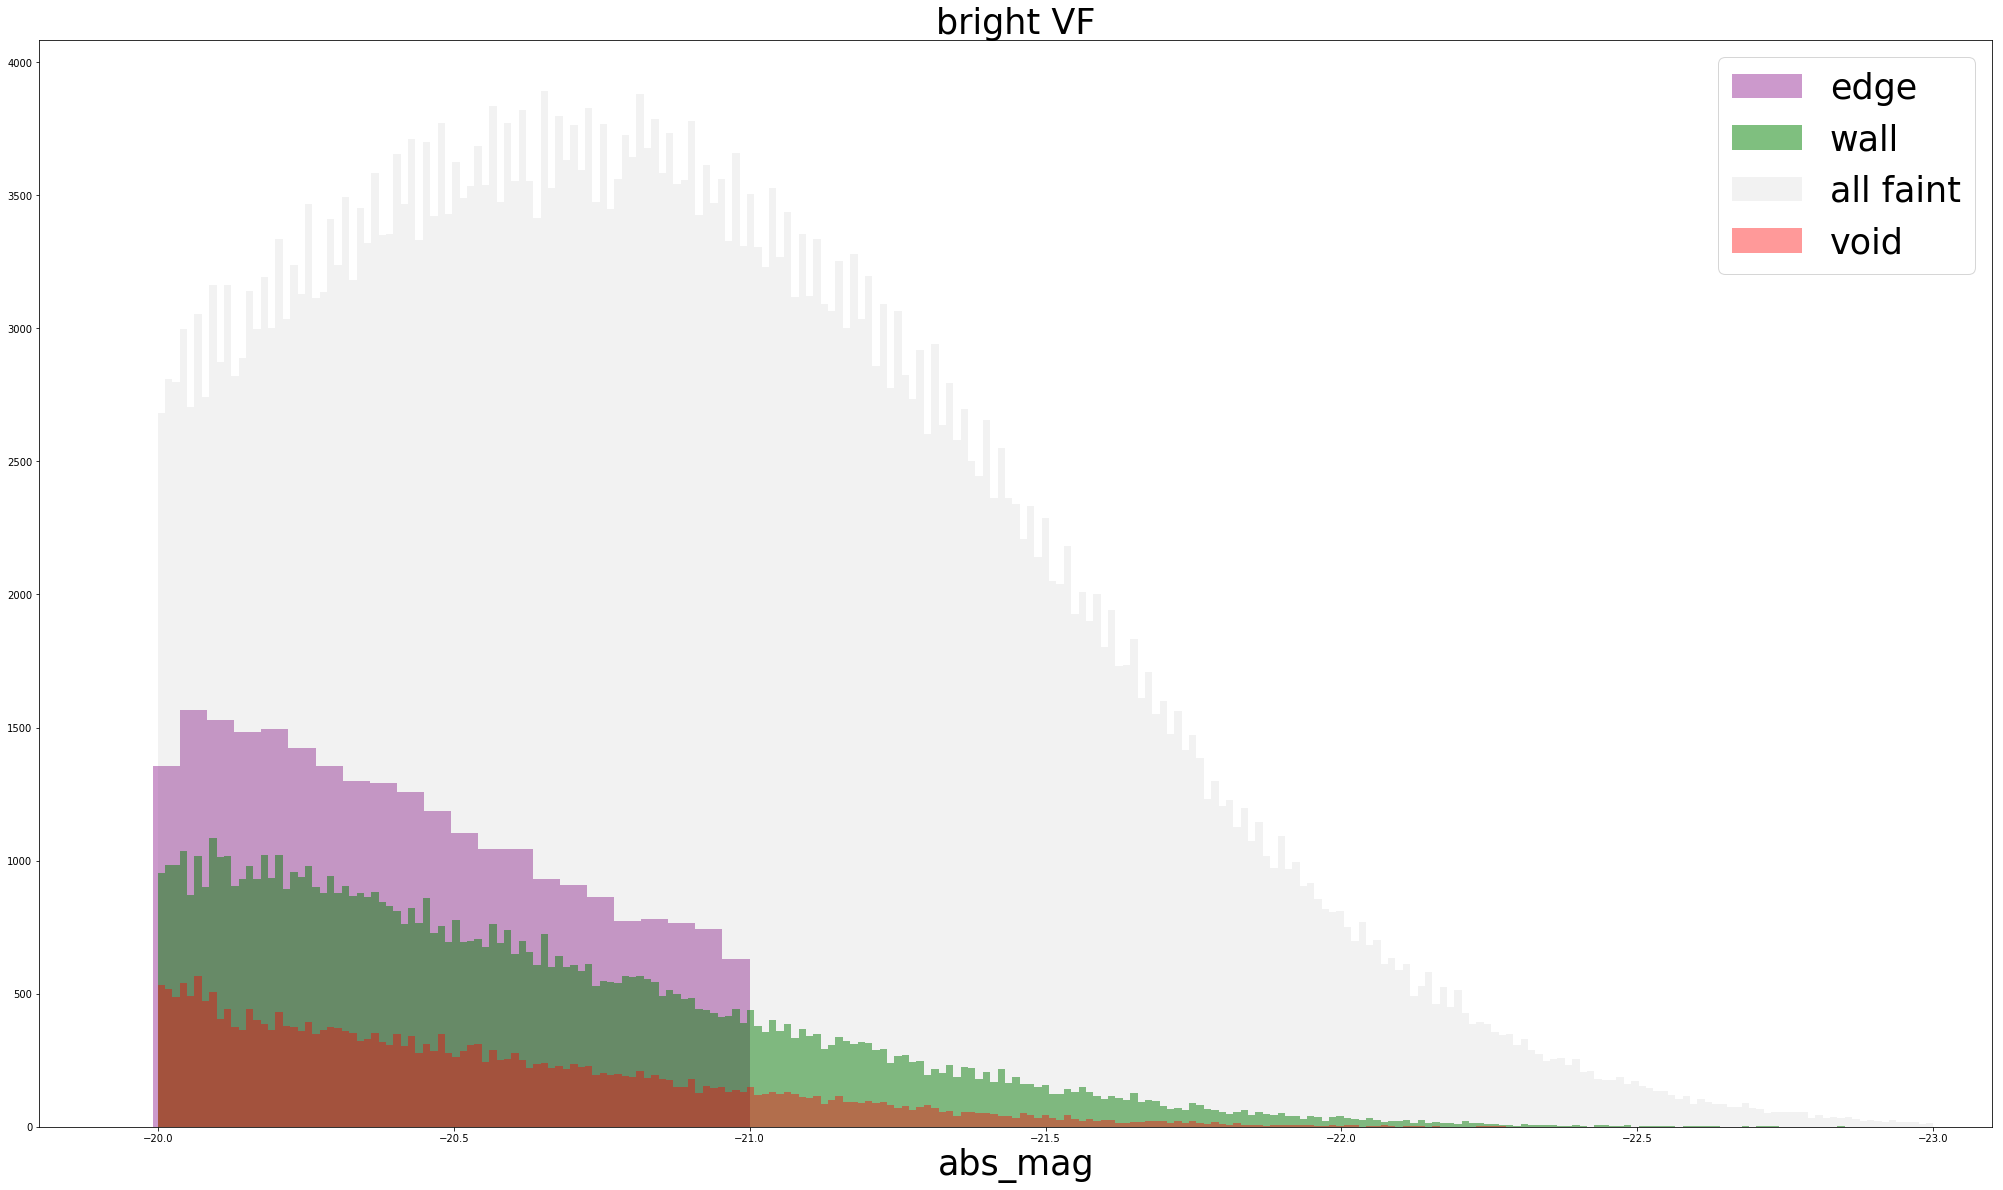

In [195]:
hist_bright()

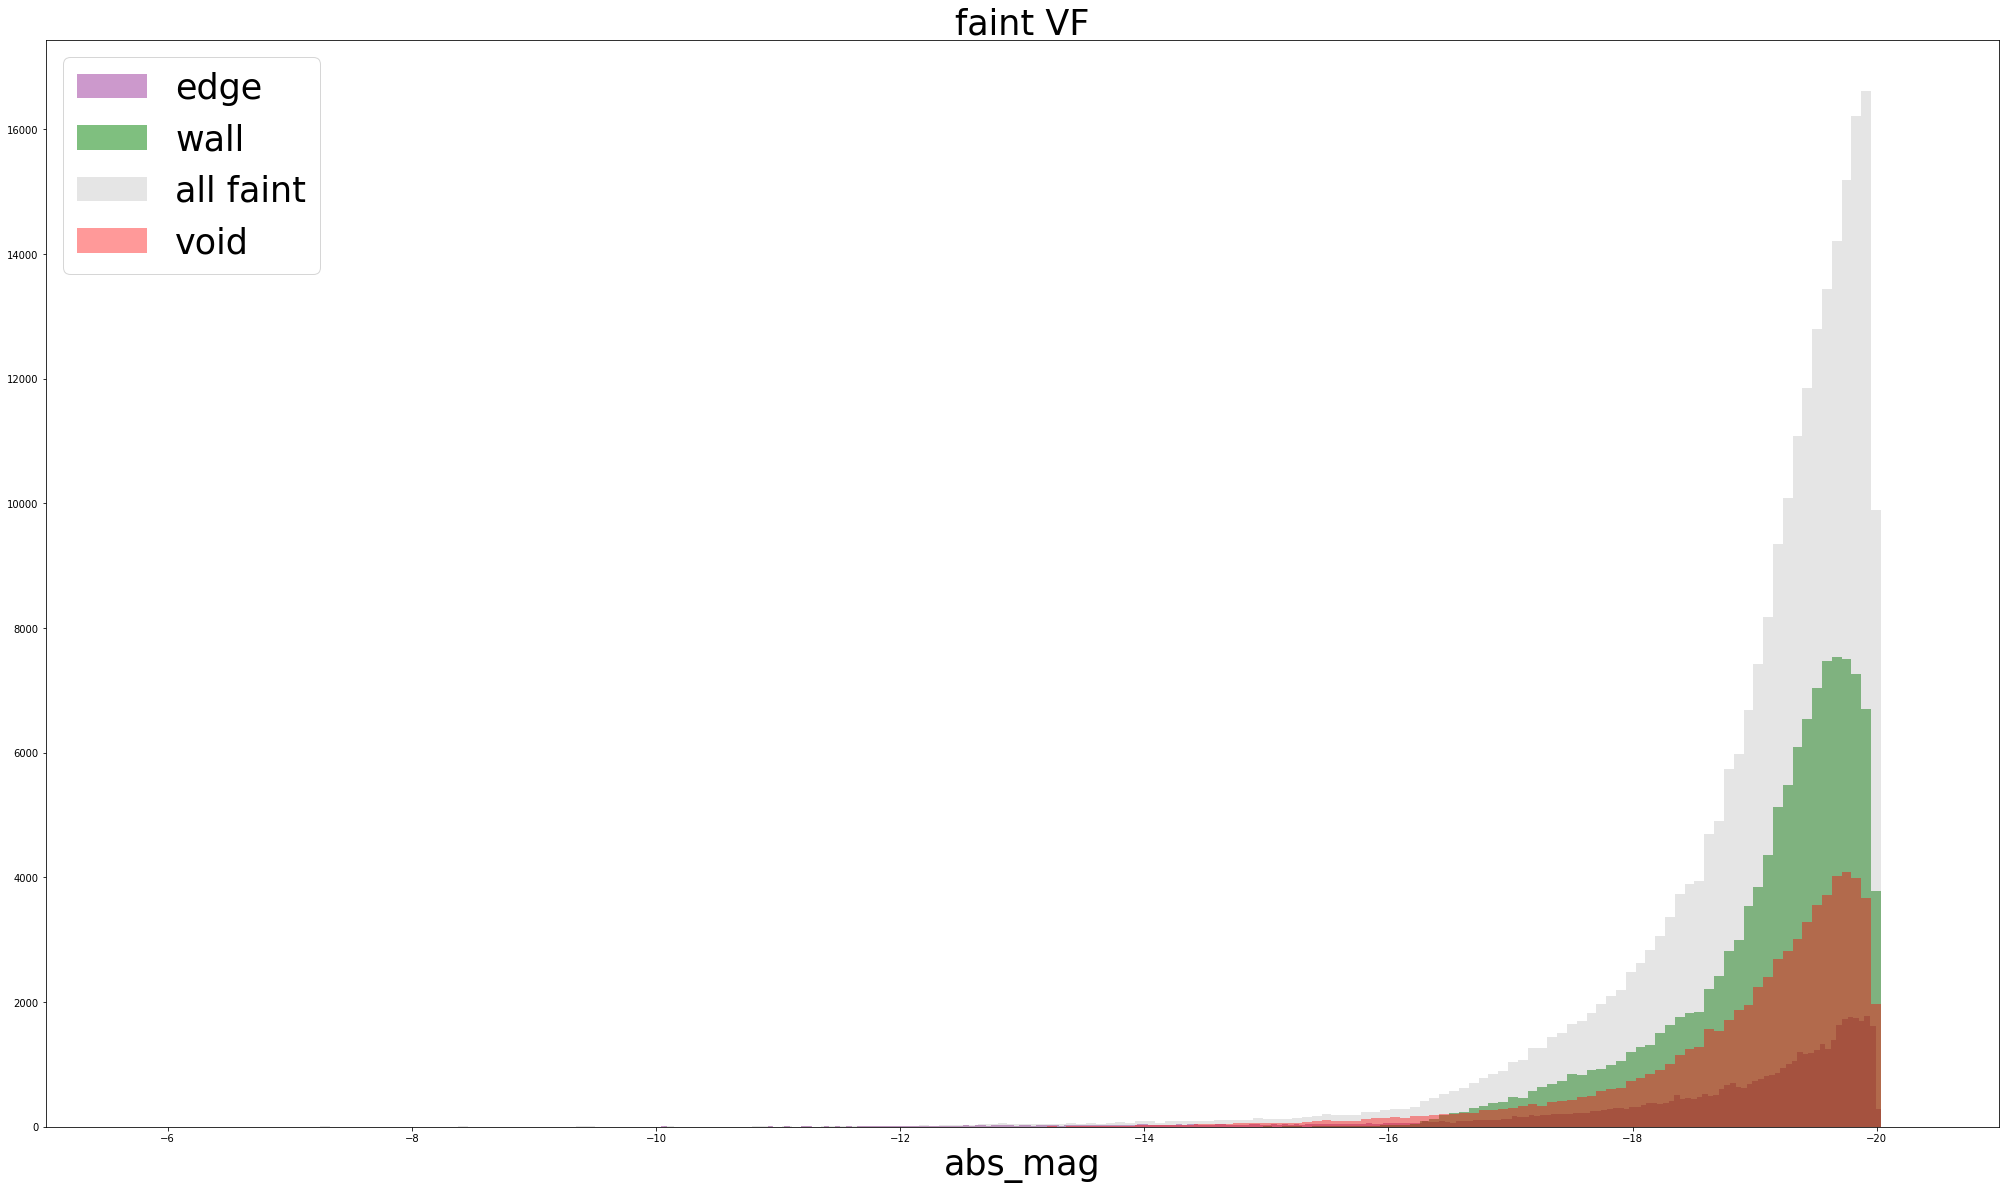

In [196]:
hist_faint()

In [201]:
len(void_vf)

95642

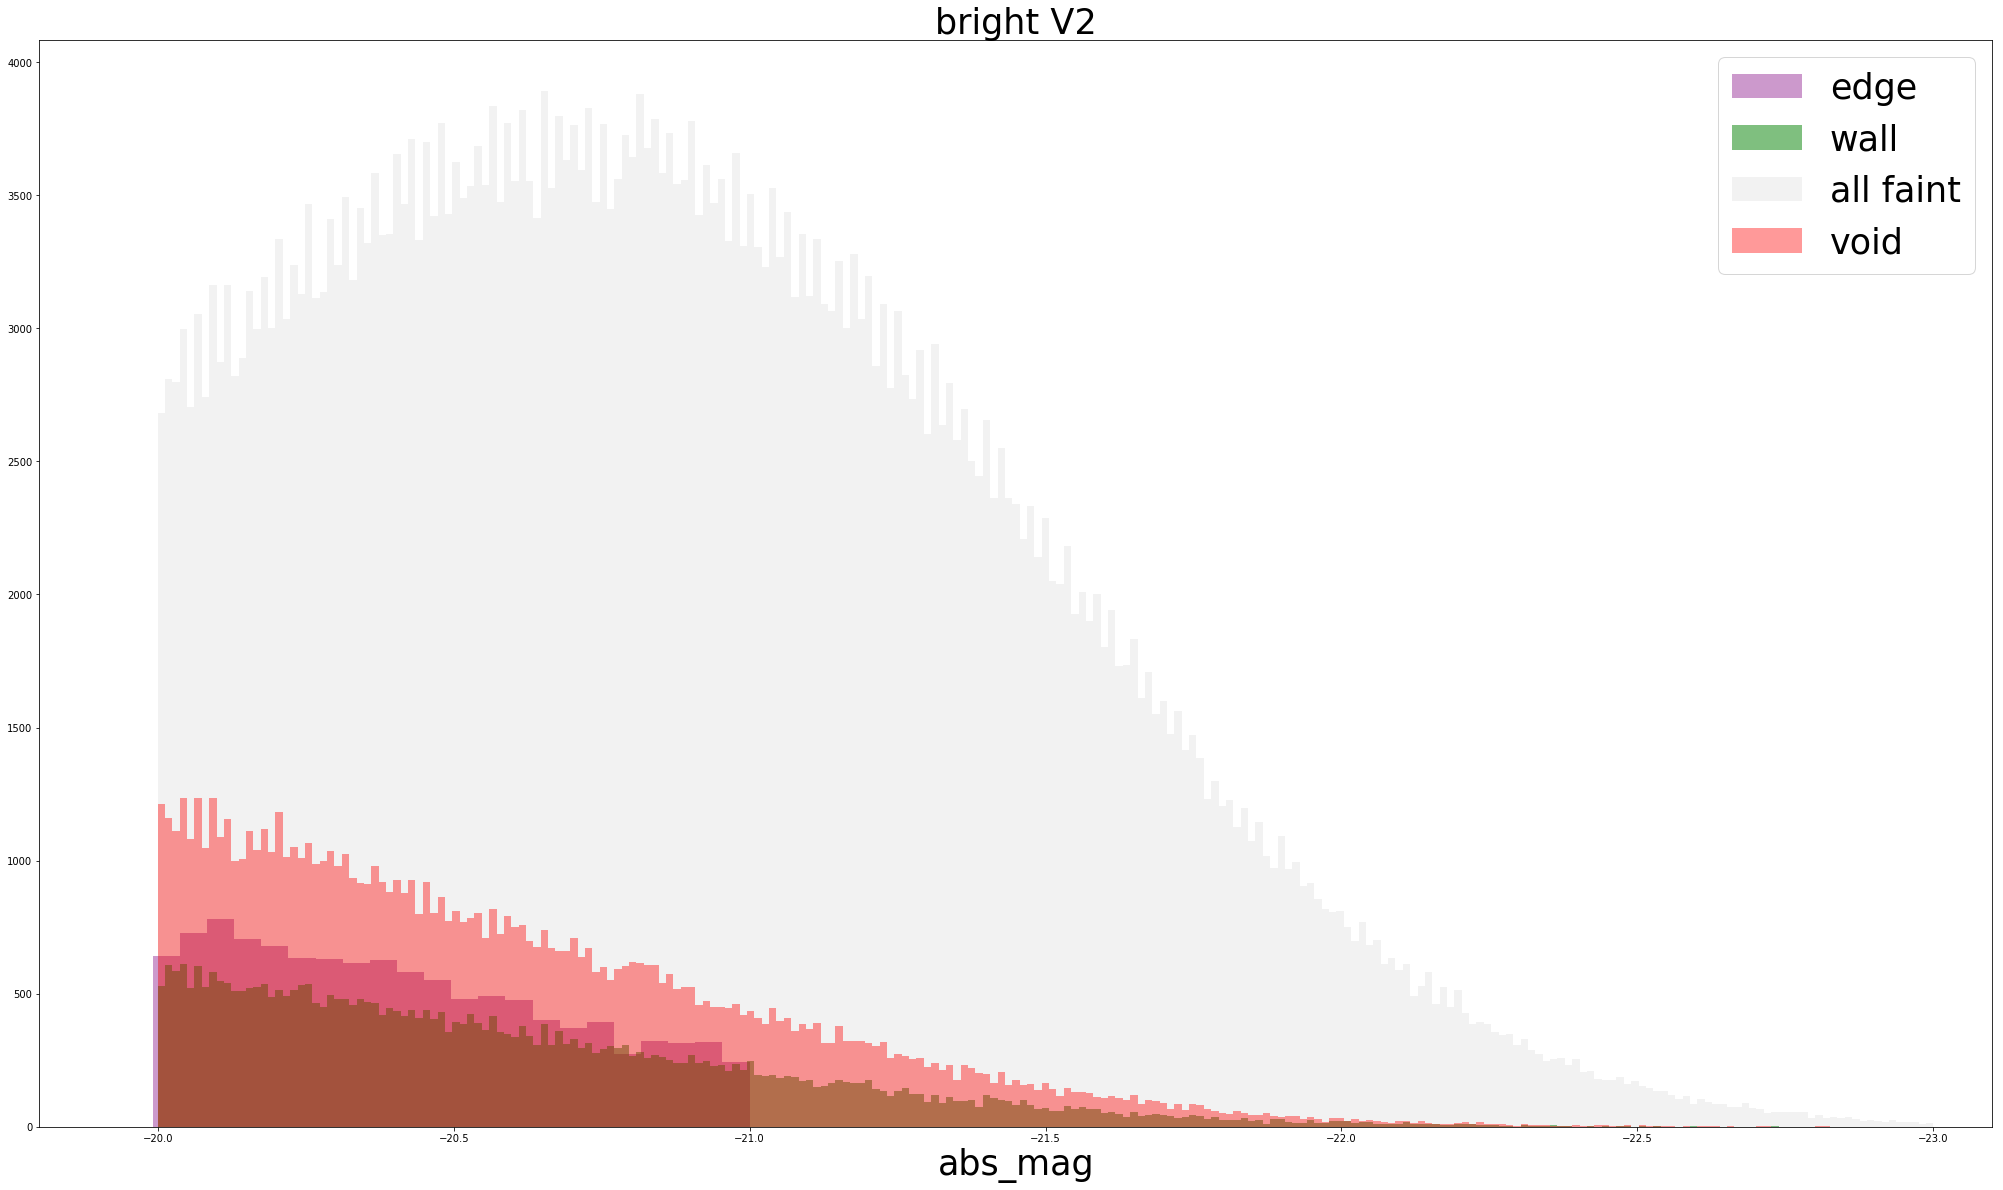

In [197]:
hist_bright(voidfinder=False)

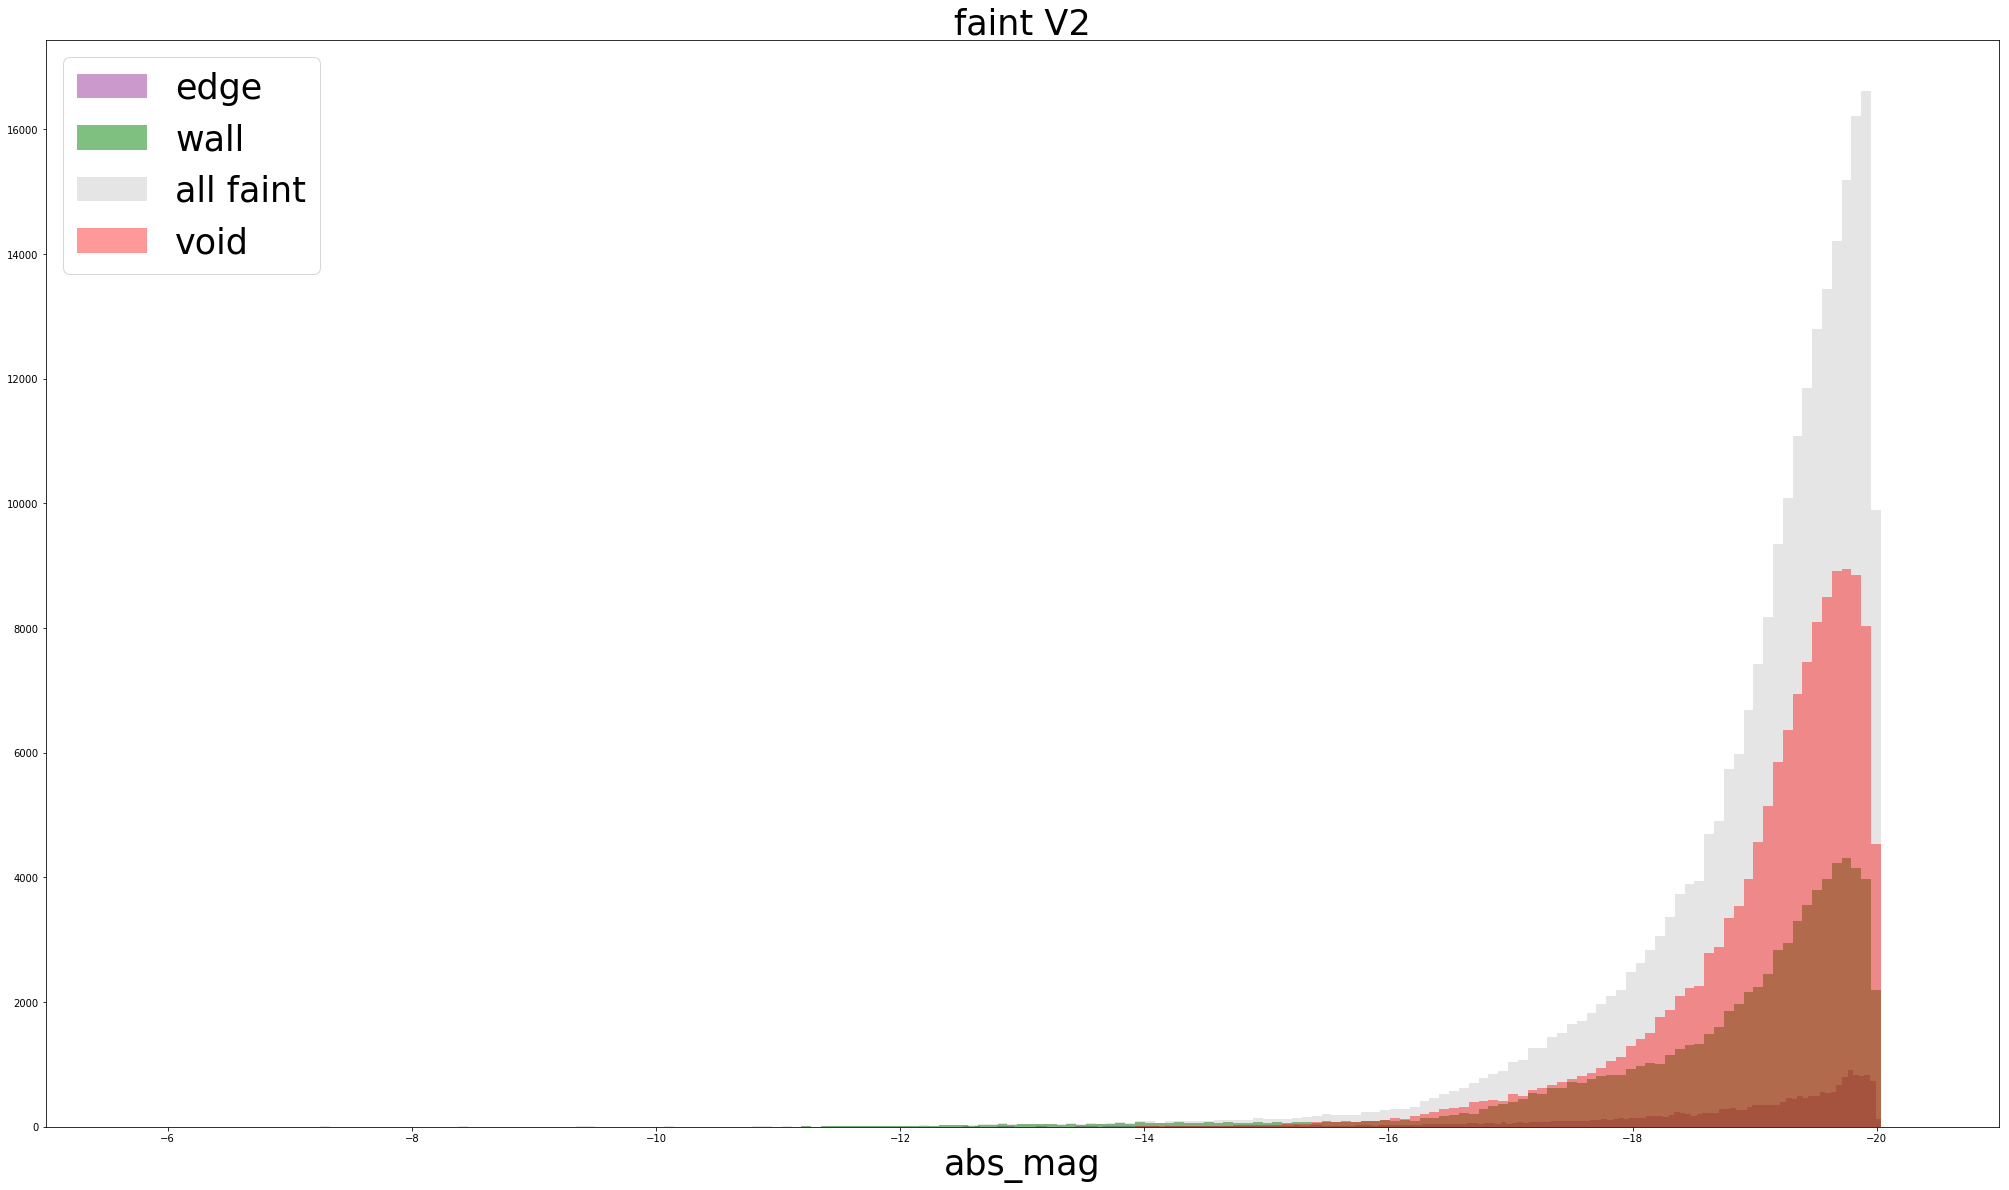

In [198]:
hist_faint(voidfinder=False)

test

In [16]:
# wall_v2_old = np.argwhere(data_old['flag_vsquared'] == 0).flatten()
# void_v2_old = np.argwhere(data_old['flag_vsquared'] == 1).flatten()
# edge_v2_old = np.argwhere(data_old['flag_vsquared'] == 2).flatten()
# out_v2_old = np.argwhere(data_old['flag_vsquared'] == 9).flatten()

# #classification voidfinder

# wall_vf_old = np.argwhere(data_old['flag_voidfinder'] == 0).flatten()
# void_vf_old = np.argwhere(data_old['flag_voidfinder'] == 1).flatten()
# edge_vf_old = np.argwhere(data_old['flag_voidfinder'] == 2).flatten()
# out_vf_old = np.argwhere(data_old['flag_voidfinder'] == 9).flatten()

In [8]:
print(len(wall_v2),len(void_v2) ,len(edge_v2),len(out_v2))
print(len(wall_vf),len(void_vf) , len(edge_vf), len(out_vf))


114507 217768 34392 341150
190881 95642 78696 342598


In [12]:
# ind_gal_maximal_voidv2 = []

# for i in range(len(ind_maximal_voidgal)):
#     ind_gal_maximal_voidv2.append(list(set(ind_maximal_voidgal[i]) & set(void_v2)))

# ind_gal_maximal_voidv2= np.array(ind_gal_maximal_voidv2)
# ind_gal_maximal_voidv2.shape

In [13]:
# galzone = Table.read('DR7_galzones.dat', format =  'ascii' )
# depth = np.array(galzone['depth'])
# galaxy_depth = []
# for i in range(np.max(depth)):
#     galaxy_depth.append(np.argwhere(depth==i))
# galaxy_depth=np.array(galaxy_depth)

In [14]:
# ind_gal_depth_voidv2 = []

# for j in range(galaxy_depth.shape[0]):
#     print(j)
#     ind_gal_depth_voidv2.append(galaxy_depth[j][np.isin(galaxy_depth[j],void_v2)])
# ind_gal_depth_voidv2= np.array(ind_gal_depth_voidv2)
# ind_gal_depth_voidv2.shape

### Where does the galaxies that are assigned a depth lie?

In [15]:
# plt.hist(z[void_v2])
# plt.show()
# plt.hist(z[gal_depth])
# plt.show()

In [16]:
# plt.figure(figsize=(45, 25))
# plt.scatter(ra[gal_depth][0.1<z<0.2], dec[gal_depth][0.1<z<0.2], color='orange', alpha=0.5, label="depth")
# # plt.scatter(ra,dec, alpha=0.01)
# # plt.scatter(ra[void_v2],dec[void_v2], alpha=0.05, label="void")
# # plt.title("dec/ra overlap of void galaxies and galaxies with depth", fontsize=45)
# # plt.legend(fontsize=45)
# # plt.xlabel("ra",fontsize=45)
# # plt.ylabel("dec",fontsize=45)
# # plt.savefig("overlap_void_depth.eps", dpi=150)
# # plt.show()

### plotting as a function of depth

In [9]:
def char_inside(char_, bins_,i, title='galaxy property', label='x-label', voidfinder=False,x=None,y=None):
    '''
    Plots a histogram for a galaxy charachterstic for wall and void galaxies for void depth analysis
    
    arguments:
    
    char_ : (numpy array) charachteristic of galaxy desired for plotting
    bins_ : (numpy linear space) histogram bins
    voidfinder : (bool) True if the classification comes from the voidfinder algorithm, False if it comes from V^2
    x: x coordinate of the location of the algorithm's name 
    y: y coordinate of the location of the algorithm's name
    '''    
#     void_vf = ind_maximal_voidgal[i]
    void_v2=ind_gal_depth_voidv2_new[i]
#     for j in range(i+1):
#         void_v2= np.append(void_v2,ind_gal_depth_voidv2_new[j])
#     void_v2.astype(int)

#     void_v2=np.array(new_depths['GAL_ID'][(new_depths['DEPTH_NORM'] != -1)])#ind_gal_depth_voidv2_new[i]
    if voidfinder == True:
        char_wall = char_[wall_vf]
        char_void = char_[void_vf]
#         char_edge = char_[edge_vf]
#         char_out = char_[out_vf]
        x_vf=x
        y_vf=y
    else:
        char_wall = char_[wall_v2]
        char_void = char_[void_v2]
#         char_edge = char_[edge_v2]
#         char_out = char_[out_v2]
        x_v2=x
        y_v2=y
    fig, ax = plt.subplots(figsize=(10, 6))
    
    counts_wall, bins_wall = np.histogram(char_wall, bins= bins_)
    counts_void, bins_void = np.histogram(char_void, bins= bins_)
    
#     counts_edge, bins_edge = np.histogram(char_edge, bins= bins_)
#     counts_out, bins_out = np.histogram(char_out, bins= bins_)
    
    counts_all, bins_all = np.histogram(char_[data['redshift']< 0.1026], bins= bins_)
    
    
    counts_wall,counts_void = np.array(counts_wall)/len(char_wall), np.array(counts_void)/len(char_void)
#     counts_edge, counts_out = np.array(counts_edge)/len(char_edge), np.array(counts_out)/len(char_out)
    counts_all = np.array(counts_all)/len(char_[data['redshift']< 0.1026])
    
    ax.hist(bins_wall[:-1], bins=bins_wall, weights=counts_wall, label = 'Wall' , color='black', histtype='step')
    ax.hist(bins_void[:-1], bins=bins_void, weights=counts_void ,label = 'Void', color = 'red',histtype='step')
    
#     ax.hist(bins_edge[:-1], bins=bins_edge, weights=counts_edge ,label = 'Edge', color = 'green',histtype='step')
#     ax.hist(bins_out[:-1], bins=bins_out, weights=counts_out ,label = 'Out', color = 'purple',histtype='step')

    ax.hist(bins_all[:-1], bins=bins_all, weights=counts_all,  label = 'All', color = 'gray',alpha = 0.3)
    
#     if (voidfinder == True) & (x!= None):
#         ax.text(x_vf, y_vf, "VoidFinder", fontsize=20)
#     if (voidfinder == False) & (x!= None):
#         ax.text(x_v2, y_v2, r'\boldmath$V^{2}$', fontsize=20)
        
    
    ax.legend(fontsize=14)
#     plt.title(title, fontsize=18)
    ax.set_xlabel(label, fontsize=20)
    ax.set_ylabel(r"Fraction of galaxies",fontsize=20)
    
    if label == 'Absolute Magnitude' or label == 'Absolute Magnitude - NSA':
        ax.set_xlim(-12, -24) 
    
    plt.savefig("Figures_V2_radius_new/g-r/"+"g-r_depth"+"{:04d}".format(i)+".png")
    plt.show()
    
    


In [4]:
# for i in range(len(ind_gal_depth_voidv2_new)):
# #     char_inside(g_r,np.linspace(-0.5,1.5, 250),i,'Color g_r - V^2',r'\boldmath$g-r$',x=-0.35,y=0.025)
#     char_inside(Mstar,np.linspace(5.5,12.5, 250),i,r'\textbf{Star Mass - }\boldmath${V^{2}}$',r'\boldmath$M_{star} [ log(M_{sun}) ]$',x=6,y=0.8*0.019)
# # char_inside(SFR,np.linspace(-3,2, 250),len(ind_gal_depth_voidv2_new)
# # ,'star formation rate ','SFR [log(Msun/yr)]',x=-2.7,y=0.0105)

In [5]:
# for i in range(len(ind_gal_depth_voidv2_new)):
# #     char_inside(g_r,np.linspace(-0.5,1.5, 250),i,'Color g_r - V^2',r'\boldmath$g-r$',x=-0.35,y=0.025)
#     char_inside(SFR,np.linspace(-3,2, 250),i,'star formation rate ','SFR [log(Msun/yr)]',x=-2.7,y=0.0105)
# # char_inside(SFR,np.linspace(-3,2, 250),len(ind_gal_depth_voidv2_new)
# # ,'star formation rate ','SFR [log(Msun/yr)]',x=-2.7,y=0.0105)

In [6]:
# for i in range(len(ind_gal_depth_voidv2_new)):
#     char_inside(g_r,np.linspace(-0.5,1.5, 250),i,'Color g_r - V^2',r'\boldmath$g-r$',x=-0.35,y=0.025)
# #     char_inside(SFR,np.linspace(-3,2, 250),i,'star formation rate ','SFR [log(Msun/yr)]',x=-2.7,y=0.0105)
# # char_inside(SFR,np.linspace(-3,2, 250),len(ind_gal_depth_voidv2_new)
# # ,'star formation rate ','SFR [log(Msun/yr)]',x=-2.7,y=0.0105)

# #     char_inside(u_r,np.linspace(0,4, 250),i,'Color u_r - V^2',r'\boldmath$u-r$',x=0.2,y=0.016)
# #     char_inside(Mstar,np.linspace(5.5,12.5, 250),i,r'\textbf{Star Mass - }\boldmath${V^{2}}$',r'\boldmath$M_{star} [ log(M_{sun}) ]$',x=6,y=0.8*0.019)
# #     char_inside(Mstar,np.linspace(5.5,12.5, 250),i,r'\textbf{Star Mass - Voidfinder}',r'\boldmath$M_{star} [ log(M_{sun}) ]$',x=6,y=0.0178)
# #     char_inside(sSFR,np.linspace(-13,-8, 250),i,'specific star formation rate - V^2','sSFR [log(1/yr)] ',x=-12.7,y=0.0105)
# # char_void(Mstar,np.linspace(5.5,12.5, 250),'Star Mass - void galaxies',r'\boldmath$Mstar [log(M_{sun})]$')
# # CDF(Mstar,np.linspace(5.5,12.5, 700),'Cumulative Star Mass',r'\boldmath$Mstar [log(M_{sun})]$')

In [10]:
# print("since the last picture still shows a difference between the void galaxies and the wall galaxies, what are the extra galaxies that are causing the shift to diseappear?")

In [26]:
# for i in range(len(ind_gal_maximal_voidv2)):

#     char_inside(Mstar,np.linspace(5.5,12.5, 250),i,r'\textbf{Star Mass - }\boldmath${V^{2}}$',r'\boldmath$M_{star} [ log(M_{sun}) ]$',x=6,y=0.8*0.019)
#     char_inside(Mstar,np.linspace(5.5,12.5, 250),r'\textbf{Star Mass - Voidfinder}',r'\boldmath$M_{star} [ log(M_{sun}) ]$', voidfinder = True,x=6,y=0.0178)
# char_void(Mstar,np.linspace(5.5,12.5, 250),'Star Mass - void galaxies',r'\boldmath$Mstar [log(M_{sun})]$')
# CDF(Mstar,np.linspace(5.5,12.5, 700),'Cumulative Star Mass',r'\boldmath$Mstar [log(M_{sun})]$')

### Overlap

In [12]:
count1 =0
for i in wall_vf:
    if i in void_v2:
        count1+=1

In [13]:
count1/len(wall_vf) #70% of V^2 void galaxies are classified wall in voidfinder

0.504377285679029

In [14]:
len(wall_vf),len(void_v2) # around 200,000 for both

(222855, 376785)

In [15]:
count2=0
test=[]
for i in void_vf:
    if i in void_v2:
        count2+=1
    else:
        test.append(i)

In [16]:
count2/len(void_vf) # 68% of voidfinder voids galaxies are classified void in V^2, the leftover 32% are classified wall.

0.5359504404560532

In [17]:
len(void_vf), len(void_v2)

(45521, 376785)

In [18]:
count3=0
for i in test:
    if i in wall_v2:
        count3+=1

In [19]:
count3/len(test) # 95% of the 32% from above are classified wall by V^2

0.9819163037303541

#### Where do these 32% live? --- nowhere specific

In [20]:
#test # voidfinder void galaxies that are mostly classified as wall in V^2

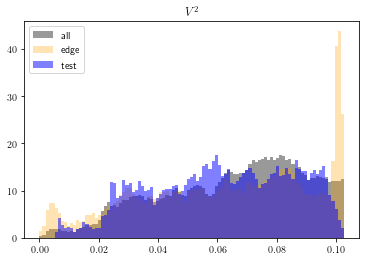

In [30]:
bins_=np.linspace(np.min(z),0.1026,100)
plt.hist(z[z< 0.1026],alpha=0.8,density=True,bins=bins_,label='all',color='gray')
plt.hist(z[edge_vf],bins=bins_,density=True,color='orange',label="edge",alpha=0.3)
plt.hist(z[test],bins=bins_,color='blue',density=True,label="test", alpha =0.5)

plt.legend()
plt.title(r"$V^{2}$")
plt.show()

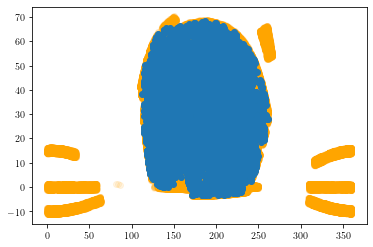

In [31]:
plt.scatter(ra[z< 0.1026], dec[z< 0.1026], color='orange', alpha=0.1)
plt.scatter(ra[test],dec[test])


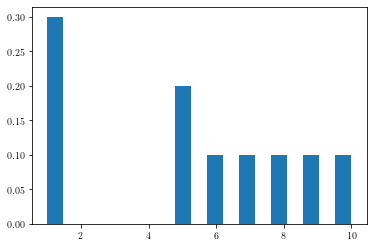

In [309]:
counts, bins = np.histogram([1,1,1,5,5,6,7,8,9,10], np.linspace(1,10, 20))
counts = np.array(counts)/ len(arr)
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

In [767]:
# ax = plt.figure(figsize=(8,4))
# all = Mstar[data['redshift']< 0.1026]
# counts_wall, bins_wall = np.histogram(Mstar[wall_vf], np.linspace(5.5,12.5, 250))
# counts_void, bins_void = np.histogram(Mstar[void_vf], np.linspace(5.5,12.5, 250))
# counts_all, bins_all = np.histogram(all, np.linspace(5.5,12.5, 250))

# counts_wall,counts_void,counts_all = np.array(counts_wall)/ len(Mstar[wall_vf]),np.array(counts_void)/ len(Mstar[void_vf]),np.array(counts_all)/ len(all)
# # plt.hist(bins_wall[:-1], bins=bins_wall, weights=counts_wall)
# # plt.hist(bins_all[:-1], bins=bins_all, weights=counts_void)
# # plt.hist(bins_all[:-1], bins=bins_all, weights=counts_all)

# ax.plt.hist(bins_wall[:-1], bins=bins_wall, weights=counts_wall, label = 'Wall' , color='black', histtype='step')
# ax.hist(bins_void[:-1], bins=bins_void, weights=counts_void ,label = 'Void', color = 'red',histtype='step')
# ax.hist(bins_all[:-1], bins=bins_all, weights=counts_all,  label = 'All', color = 'gray',alpha = 0.3)
# ax.title('Star Mass - Voidfinder')
# ax.ylabel(r"$\frac{count}{total}=$ (Fraction)",fontsize=16)
# ax.legend()
# ax.show()

In [7]:
# def CDF(char_, bins_, title='galaxy property', label='x-label'):
#     '''
#     Plots the cumulative distribution for void,wall galaxies for both algorithms for a given galaxy property
    
#     arguments:
    
#     char_ : (numpy array) charachteristic of galaxy desired for plotting
#     bins_ : (numpy linear space) histogram bins
#     '''

#     fig, ax = plt.subplots(figsize=(20, 6))

#     ax.hist(char_[void_vf].flatten(), bins=bins_, density=True, histtype='step', label='VoidFinder Void', cumulative=True, color='red')
#     ax.hist(char_[wall_vf].flatten(), bins=bins_, density=True, histtype='step', label='VoidFinder Wall',cumulative=True, color='red',linestyle='-.')
#     ax.hist(char_[void_v2], bins=bins_, density=True, histtype='step', label= r'$V^{2}$ Void',cumulative=True, color='blue')
#     ax.hist(char_[wall_v2], bins=bins_, density=True, histtype='step', label= r'$V^{2}$ Wall',cumulative=True,linestyle='-.', color='blue')
#     ax.hist(char_[data['redshift']< 0.1026], bins=bins_, density=True, histtype='step', label='All galaxies',cumulative=True, color='gray')

#     ax.grid(True)
#     ax.legend(loc='upper right',fontsize=18)
# #     ax.set_title(title)
#     ax.set_xlabel(label,fontsize=20)
#     ax.set_ylabel('Likelihood of occurrence',fontsize=20)

#     if label == 'Absolute Magnitude' or label == 'Absolute Magnitude - NSA':
#         ax.set_xlim(-12, -24) 
        
# #     plt.savefig('figures/'+title+".png")
#     plt.show()

#### Star Mass

In [8]:
# def scott_bin_width(data, return_bins=False):
#     """
#         Scott's rule is a normal reference rule: it minimizes the integrated
#     mean squared error in the bin approximation under the assumption that the
#     data is approximately Gaussian.
#     """
#     data = np.asarray(data)
#     if data.ndim != 1:
#         raise ValueError("data should be one-dimensional")

#     n = data.size
#     sigma = np.std(data)
#     dx = 3.5 * sigma / (n ** (1 / 3))
#     if return_bins:
#         Nbins = np.ceil((data.max() - data.min()) / dx)
#         Nbins = max(1, Nbins)
#         bins = data.min() + dx * np.arange(Nbins + 1)
#         return dx, bins
#     else:
#         return dx

In [9]:
# def freedman_bin_width(data, return_bins=False):
#     """
#         The Freedman-Diaconis rule is a normal reference rule like Scott's
#     rule, but uses rank-based statistics for results which are more robust
#     to deviations from a normal distribution.
    
#     """
#     data = np.asarray(data)
#     if data.ndim != 1:
#         raise ValueError("data should be one-dimensional")

#     n = data.size
#     if n < 4:
#         raise ValueError("data should have more than three entries")

#     v25, v75 = np.percentile(data, [25, 75])
#     dx = 2 * (v75 - v25) / (n ** (1 / 3))
#     if return_bins:
#         dmin, dmax = data.min(), data.max()
#         Nbins = max(1, np.ceil((dmax - dmin) / dx))
#         try:
#             bins = dmin + dx * np.arange(Nbins + 1)
#         except ValueError as e:
#             if 'Maximum allowed size exceeded' in str(e):
#                 raise ValueError(
#                     'The inter-quartile range of the data is too small: '
#                     'failed to construct histogram with {} bins. '
#                     'Please use another bin method, such as '
#                     'bins="scott"'.format(Nbins + 1))
#             else:  # Something else  # pragma: no cover
#                 raise
#         return dx, bins
#     else:
#         return dx

In [10]:
# class _KnuthF:
#     r"""Class which implements the function minimized by knuth_bin_width
# """
#     def __init__(self, data):
#         self.data = np.array(data, copy=True)
#         if self.data.ndim != 1:
#             raise ValueError("data should be 1-dimensional")
#         self.data.sort()
#         self.n = self.data.size

#         # import here rather than globally: scipy is an optional dependency.
#         # Note that scipy is imported in the function which calls this,
#         # so there shouldn't be any issue importing here.
#         from scipy import special

#         # create a reference to gammaln to use in self.eval()
#         self.gammaln = special.gammaln

#     def bins(self, M):
#         """Return the bin edges given a width dx"""
#         return np.linspace(self.data[0], self.data[-1], int(M) + 1)

#     def __call__(self, M):
#         return self.eval(M)

#     def eval(self, M):
#         """Evaluate the Knuth function

#         Parameters
#         ----------
#         dx : float
#             Width of bins

#         Returns
#         -------
#         F : float
#             evaluation of the negative Knuth likelihood function:
#             smaller values indicate a better fit.
#         """
#         M = int(M)

#         if M <= 0:
#             return np.inf

#         bins = self.bins(M)
#         nk, bins = np.histogram(self.data, bins)

#         return -(self.n * np.log(M) +
#                  self.gammaln(0.5 * M) -
#                  M * self.gammaln(0.5) -
#                  self.gammaln(self.n + 0.5 * M) +
#                  np.sum(self.gammaln(nk + 0.5)))

# def knuth_bin_width(data, return_bins=False, quiet=True):
#     r"""Return the optimal histogram bin width using Knuth's rule.

#     Knuth's rule is a fixed-width, Bayesian approach to determining
#     the optimal bin width of a histogram.
# """

#     # import here because of optional scipy dependency
#     from scipy import optimize

#     knuthF = _KnuthF(data)
#     dx0, bins0 = freedman_bin_width(data, True)
#     M = optimize.fmin(knuthF, len(bins0), disp=not quiet)[0]
#     bins = knuthF.bins(M)
#     dx = bins[1] - bins[0]

#     if return_bins:
#         return dx, bins
#     else:
#         return dx

In [11]:
# scott_bin_width(Mstar[np.logical_not(np.isnan(Mstar))] )

In [12]:
# freedman_bin_width(Mstar[np.logical_not(np.isnan(Mstar))] )

In [13]:
# knuth_bin_width(Mstar[np.logical_not(np.isnan(Mstar))] )

In [14]:
# np.linspace(5.5,12.5, 155)[-4]-np.linspace(5.5,12.5, 155)[-5]

In [ ]:
# char(g_r,np.linspace(-0.5,1.5, 250),'Color g_r - V^2',r'\boldmath$g-r$',x=-0.35,y=0.025)
char_inside(g_r,np.linspace(-0.5,1.5, 250),'Color g_r - Voidfinder',r'\boldmath$g-r$', voidfinder = True,x=-0.35,y=0.025)
# char_void(g_r,np.linspace(-0.5,1.5, 250),'Color g_r - void galaxies',r'\boldmath$g-r$')
# CDF(g_r,np.linspace(-0.5,1.5, 700),'Cumulative Color g_r',r'\boldmath$g-r$')

In [ ]:
char_inside(sSFR,np.linspace(-13,-8, 250),'specific star formation rate - V^2','sSFR [log(1/yr)] ',x=-12.7,y=0.0105)
# char(sSFR,np.linspace(-13,-8, 250),'specific star formation rate - Voidfinder','sSFR [log(1/yr)]', voidfinder = True,x=-12.7,y=0.013)
# char_void(sSFR,np.linspace(-13,-8, 250),'specific star formation rate- void galaxies','sSFR [log(1/yr)] ')
# CDF(sSFR,np.linspace(-13,-8, 700),'Cumulative specific star formation rate','sSFR [log(1/yr)] ')